In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple
import matplotlib.ticker as ticker
from scipy import stats



In [2]:
cell_nums = np.arange(3,97,1)
cell_nums_str = ["{:03d}".format(cell) for cell in cell_nums]
cell_nums_str.remove("083") # shorted cell
cell_nums_str.remove("018") # shorted cell
cells = ["cell_" + cell_num_str for cell_num_str in cell_nums_str]


In [3]:
#plotting parameters for uniformity
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams["font.family"] = "Arial"

#legend handlers:
def legend_without_duplicate_labels(ax,loc = 0,fontsize =12):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique),loc= loc,fontsize =fontsize)

#plot params
mydpi = 250
myfontsize = 12
mytickfontsize = 10
mytextfontsize = mytickfontsize
legend_framewidth = 0.5
ax_framewidth =0.65
myframecolor = 'black'
mylinewidth =0.8
mylegendalpha = 0.8
mywpadding = 0.1
myhpadding = 0.1
myspacing = 0.06

## Loading data

Loading metadata and diagnostic all

In [4]:
data = pd.read_pickle('./data/metadata.pkl')
dataws = data[~data['protocol_variant'].str.contains('% storage')]
data.head(5)

,cell_name,protocol_type,protocol_variant,avg_Crate,avg_crate_exp,protocol_name
0,cell_003,CC,(5% storage),Co10,0.060343,CC_(5%_storage)_Co10
1,cell_004,CC,(5% storage),Co10,0.060326,CC_(5%_storage)_Co10
2,cell_005,CC,(50% storage),Co10,0.060297,CC_(50%_storage)_Co10
3,cell_006,CC,(50% storage),Co10,0.060288,CC_(50%_storage)_Co10
4,cell_007,CC,(100% storage),Co10,0.060253,CC_(100%_storage)_Co10


In [5]:
#loading diagnostic_features_all
dfa = pd.read_pickle('./data/diagnostic_features_all.pkl')
print(dfa.shape)
dfa


(1885, 2)


C/2 discharge CC Capacity [normalized]         EFCs
Cell     Cycle                                                      
cell_003 1.0                                   0.986467     1.988955
         28.0                                  0.977759    33.110782
         55.0                                  0.970296    61.834839
         82.0                                  0.962882    90.281904
         109.0                                 0.955736   118.465877
...                                                 ...          ...
cell_096 1044.0                                0.838402   925.267618
         1146.0                                0.817030  1007.734517
         1248.0                                0.815608  1087.271668
         1350.0                                0.804960  1167.107351
         1452.0                                0.795704  1247.267103

[1885 rows x 2 columns]

## Extracting the data for plots

In [6]:
#creating our buckets containing our cells of interest
crates = ['Co10', 'Co5', 'Co2']
buckets_woCC = {}  #contains all cells cycled dynamically
buckets_nostorage = {} #contains CC cells without any storage 
other_buckets = {} # contains CC cells with storage + cells that are too much out of buckets

for i, crate in enumerate (crates):
    buckets_woCC[crate] = list(data[(data['avg_Crate']==crate) & (data['protocol_type']!='CC')]['cell_name'].values)
    buckets_nostorage[crate] = list(data[(data['avg_Crate']==crate) & (data['protocol_variant'].str.contains('no storage'))]['cell_name'].values)
    other_buckets[crate+'_storage'] = list(data[(data['avg_Crate']==crate) & (data['protocol_variant'].str.contains('% storage'))]['cell_name'].values)

buckets_woCCm = buckets_woCC.copy() #contains dynamic cells, modified by removing slightly variants protocols
buckets_woCCm['Co2'] = [cell for cell in buckets_woCCm['Co2'] if cell not in ['cell_045','cell_046']] # the two cells at 0.6
buckets_woCCm['Co2'] = [cell for cell in buckets_woCCm['Co2'] if cell not in ['cell_069','cell_070']] # the two cells at 0.44
buckets_woCCm['Co5'] = [cell for cell in buckets_woCCm['Co5'] if cell not in ['cell_087','cell_088']] # the two cells at 0.25
buckets_woCCm['Co10'] = [cell for cell in buckets_woCCm['Co10'] if cell not in ['cell_071','cell_072']] # the two cells at 0.12

#three main buckets to plot the figure
buckets3 = {} 
for k,v in buckets_woCCm.items():
    buckets3[k]=buckets_woCCm[k]+buckets_nostorage[k]
    
#other buckets
other_buckets['0p6'] = ['cell_045','cell_046']
other_buckets["0p44"] = ['cell_069','cell_070']
other_buckets['0p25']=['cell_087','cell_088']

other_buckets['Co10_storage']+=list(data[(data['avg_Crate']=='Co16')]['cell_name'].values)
not_fullDOD = ['cell_089','cell_090','cell_093','cell_094']
other_buckets['Co10_storage']=[element for element in other_buckets['Co10_storage'] if element not in not_fullDOD]
other_buckets['Co2_storage']+=['cell_071','cell_072']


In [7]:
#let's define our SOH of interest and our metric
eol_capacity_metric = "C/2 discharge CC Capacity [normalized]"
EFC_metric ='EFCs' 
SOHs =np.linspace(1,0.85,31)
chosen_SOH = 0.90
# chosen_SOH2 = 0.95
# chosen_SOH3 = 0.85
# idx_chosen_SOH =np.where(SOHs == chosen_SOH)[0]
SOHs

array([1.   , 0.995, 0.99 , 0.985, 0.98 , 0.975, 0.97 , 0.965, 0.96 ,
       0.955, 0.95 , 0.945, 0.94 , 0.935, 0.93 , 0.925, 0.92 , 0.915,
       0.91 , 0.905, 0.9  , 0.895, 0.89 , 0.885, 0.88 , 0.875, 0.87 ,
       0.865, 0.86 , 0.855, 0.85 ])

In [8]:
#let's collect all SOHs for all cells

#Smoothing capacity decay curve to be strictly decreasing
def remove_invalid_points(cycle, capacity):
    filtered_cycle = cycle.copy()
    filtered_capacity = capacity.copy()
    for i in range(len(cycle) - 1, 0, -1):
        if capacity[i] > capacity[i - 1]:
            filtered_cycle = np.delete(filtered_cycle, i-1)
            filtered_capacity = np.delete(filtered_capacity, i-1)
    return filtered_cycle, filtered_capacity

allSOHs = np.zeros((len(cells),len(SOHs)))
for i,cell in enumerate(cells):
    capa = np.array(dfa.loc[cell][eol_capacity_metric].values)
    EFCs = np.array(dfa.loc[cell][EFC_metric])
    EFCs,capa = remove_invalid_points(EFCs,capa)
    eol = np.round(np.interp(SOHs*capa[0],np.flip(capa),np.flip(EFCs),left = np.nan, right = np.nan),1)
    eol[0]=0
    allSOHs[i]=eol
allSOHs_pd =pd.DataFrame(allSOHs,index = cells,columns = np.round(SOHs,3))

#if needed, merging with data: 
merged = pd.merge(data,allSOHs_pd,left_on='cell_name',right_index=True)



In [9]:
#getting all protocols with repeats
all_prots = data['protocol_name'].unique()
all_prots = all_prots[(all_prots!='CC_(no_storage)_Co2')&(all_prots!='Synthetic_2c_Co5')] #removing the two protocols with only one cell because of cell failure

intrinsic_var = np.ones((len(all_prots),len(SOHs)))
for i, prot in enumerate(all_prots):
    twocells = data[data['protocol_name']==prot]['cell_name'].tolist()
    #getting the variability between these two cells cycled with this protocol
    mymean = allSOHs_pd.loc[twocells].mean()
    mymean.iloc[0]=1
    intrinsic_var[i]=(allSOHs_pd.loc[twocells].max()-allSOHs_pd.loc[twocells].min())/mymean

intrinsic_pd = pd.DataFrame(intrinsic_var,index = all_prots,columns = np.round(SOHs,3))

## Plotting 2a

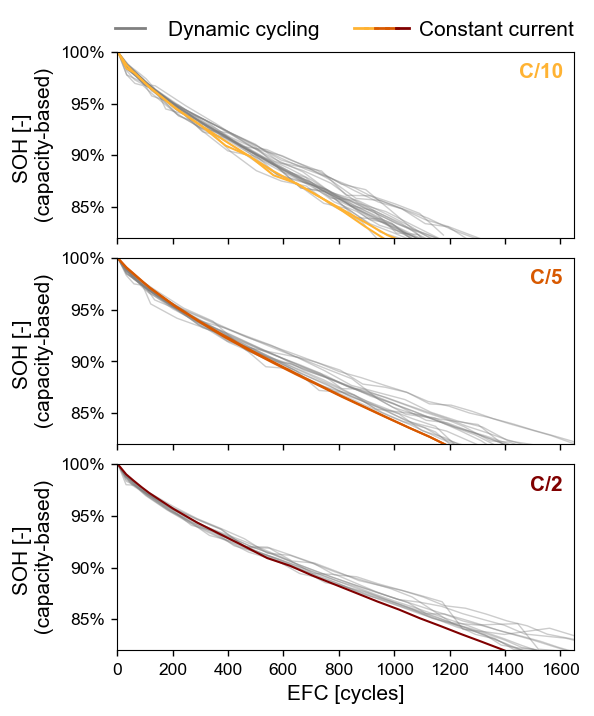

In [10]:
myfontsize2a = myfontsize
mytickfontsize2a =mytickfontsize
my_ylim = [0.82,1]
my_xlim = [0,1650]
metric = eol_capacity_metric
EFCcapa = EFC_metric
current_colors_dic = plt.get_cmap('afmhot')(np.flip(np.linspace(0.25,0.6,3)))
legend_tuple = ()
legend_labels = []
legend_labels.append("Dynamic cycling")
legend_labels.append("Constant current")

fig,ax =plt.subplots(3,1,figsize =(4.77,5.7),dpi = mydpi/2)
plt.subplots_adjust(top=0.92, bottom =0.08, left=0.184, right=0.95,hspace=0.45)  
plt.subplots_adjust(hspace=myspacing*1.8)

for i, crate in enumerate(crates):
    for cell in buckets_woCCm[crate]:
        EFC_array = np.array(dfa.loc[cell][EFCcapa])
        capa_array = np.array(dfa.loc[cell][metric].values/dfa.loc[cell][metric].values[0])
        EFC_array_filtered, capa_array_filtered = remove_invalid_points(EFC_array, capa_array)
        DC_curve, = ax[i].plot(EFC_array_filtered,capa_array_filtered,c='gray',linewidth =mylinewidth,alpha=0.4,label= 'Dynamic cycling',zorder =1)
    for cell in buckets_nostorage[crate]:
        EFC_array = np.array(dfa.loc[cell][EFCcapa])
        capa_array = np.array(dfa.loc[cell][metric].values/dfa.loc[cell][metric].values[0])
        EFC_array_filtered, capa_array_filtered = remove_invalid_points(EFC_array, capa_array)
        ax[i].plot(EFC_array_filtered,capa_array_filtered,c=current_colors_dic[i],linewidth =mylinewidth*1.5,label= 'Constant current',zorder =1)
        CC_curve, = ax[i].plot([],[],c=current_colors_dic[i],linewidth =mylinewidth*2,label= 'Constant current',zorder =1)
        legend_tuple += (CC_curve,)

    x_pos = [1530,1550,1550]
    ax[i].text(x_pos[i],0.98, f"C/{crate[2:]}", fontsize=myfontsize2a, fontweight='bold',  horizontalalignment='center',verticalalignment='center',color=current_colors_dic[i], bbox=dict(facecolor='white', edgecolor='none',linewidth = legend_framewidth,pad  = 0.1))
    
    ax[i].set_ylabel("SOH [-] \n (capacity-based) ",fontsize = myfontsize2a)
    ax[i].tick_params(axis='both', labelsize=myfontsize2a)
    ax[i].set_ylim(my_ylim)
    ax[i].set_xlim(my_xlim)
    ax[i].yaxis.set_major_locator(ticker.FixedLocator([1,0.95,0.9,0.85]))
    ax[i].set_yticklabels(['{:.0f}%'.format(x*100) for x in ax[i].get_yticks()])
    ax[i].xaxis.set_major_locator(ticker.LinearLocator(5))
    ax[i].tick_params(axis='both', colors= myframecolor,labelsize=mytickfontsize2a)
    my_xticks = np.arange(0,my_xlim[1],200)
    ax[i].xaxis.set_major_locator(ticker.FixedLocator(my_xticks))
    if i!=2:
        ax[i].set_xticklabels([])
    if i == 2:
        ax[i].set_xlabel("EFC [cycles]",fontsize = myfontsize2a)
        
DC_handle = (Line2D([], [], color='gray',linewidth = mylinewidth*2))
mylegend = fig.legend([DC_handle,legend_tuple],legend_labels, loc='outside upper center',ncol = 2,fontsize =myfontsize,frameon = False,numpoints = 2,handler_map={tuple: HandlerTuple(ndivide=None,pad = 0.5)},bbox_to_anchor=(0.56,0.99))
mylegend.get_frame().set_edgecolor(myframecolor)
mylegend.get_frame().set_linewidth(legend_framewidth)
mylegend.get_frame().set_alpha(1)

#thickness of the frame
for axy in ax:
    axy.spines['top'].set_linewidth(ax_framewidth)
    axy.spines['bottom'].set_linewidth(ax_framewidth)
    axy.spines['right'].set_linewidth(ax_framewidth)
    axy.spines['left'].set_linewidth(ax_framewidth)

    axy.spines['top'].set_color(myframecolor)
    axy.spines['bottom'].set_color(myframecolor)
    axy.spines['right'].set_color(myframecolor)
    axy.spines['left'].set_color(myframecolor)


## Plotting 2b

Max deviation from CC at C/10 is  30.1
Max spread normalized by CC at C/10 is  31.0
Max deviation from CC at C/5 is  38.4
Max spread normalized by CC at C/5 is  38.6
Max deviation from CC at C/2 is  26.1
Max spread normalized by CC at C/2 is  26.1


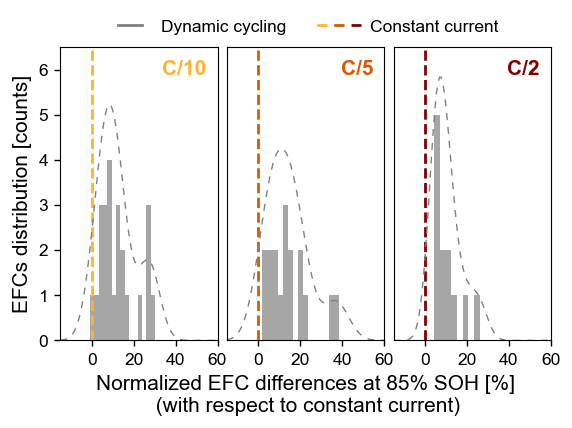

In [11]:
myfontsize2b = myfontsize
mytickfontsize2b = mytickfontsize
distribution_SOH = 0.85
labels = []
kdepoints =100
bins_nb = [15,15,8]
scalings = [110,110,90]
my_xlim2b = [-15,60]
my_ylim2b = [0,6.5]

fig,axs =plt.subplots(1,3,figsize =(4.67,3.45),dpi = mydpi/2)
plt.subplots_adjust(wspace=myspacing)
plt.subplots_adjust(top=0.88, bottom =0.20, left=0.14, right=0.98,hspace=0.45)

#legend handles and labels
legend_handles = []
legend_labels = []
legend_handles.append(Line2D([], [], color='gray'))
legend_labels.append("Dynamic cycling")
legend_labels.append("Constant current")
legend_tuple = ()

for i, crate in enumerate(crates):
    labels.append(f"C/{crate[2:]}")
    CC_cells = data[(data['avg_Crate']==crate) & (data['protocol_type']=='CC') & ~(data['protocol_variant'].str.contains('% storage'))]['cell_name'].values
    CC_mean = allSOHs_pd.loc[CC_cells,distribution_SOH].mean()

    subdata_withCC = (allSOHs_pd.loc[buckets3[crate],distribution_SOH]-CC_mean)/CC_mean *100
    subdata = subdata_withCC[~subdata_withCC.index.isin(CC_cells)] #remove the CC_cells from the subdata
    kde = stats.gaussian_kde(subdata)
    kde_x_values = np.linspace(my_xlim2b[0],my_xlim2b[1],kdepoints)
    print(f"Max deviation from CC at C/{crate[2:]} is ",round(subdata.max(),1))
    print(f"Max spread normalized by CC at C/{crate[2:]} is ",round(subdata_withCC.max()-subdata_withCC.min(),1))
    
    #actual plotting
    axs[i].hist(subdata,bins = bins_nb[i],histtype='bar',color = 'gray',alpha = 0.7)
    CC_vline =axs[i].axvline(x=0, color=current_colors_dic[i], linestyle='--',linewidth = mylinewidth*2,label = 'Constant current')
    legend_tuple+=(CC_vline,)
    kde_curve, = axs[i].plot(kde_x_values,kde(kde_x_values)*scalings[i],'--', dashes=(5, 5),linewidth = mylinewidth,c = 'gray',label = 'Dynamic Cycling')
    kde_curve, = axs[i].plot([],[],linewidth = mylinewidth*2,c = 'gray',label = 'Dynamic Cycling')
    
    # C-rate legend
    x_pos = [28.2,31,31]
    mytext = axs[i].text(x_pos[i]+16, 4.52+1.5, f"C/{crate[2:]}", fontsize=myfontsize2b, fontweight='bold',  horizontalalignment='center',verticalalignment='center',color=current_colors_dic[i], bbox=dict(facecolor='white', edgecolor='none',linewidth = legend_framewidth,pad  = 0.1))

    # axes design
    axs[i].set_xlim(my_xlim2b)
    axs[i].xaxis.set_major_locator(ticker.MultipleLocator(20))
    axs[i].set_ylim(my_ylim2b)
    axs[i].tick_params(axis='both',labelsize=mytickfontsize2b)
    if i != 0:
        axs[i].set_yticklabels([])
        axs[i].set_yticks([])

axs[0].set_ylabel("EFCs distribution [counts]",fontsize = myfontsize2b)
axs[1].set_xlabel(r"Normalized EFC differences at "+ str(int(100*distribution_SOH)) +"% SOH [%]\n (with respect to constant current)",fontsize = myfontsize2b)

#thickness of the frame
for axy in axs:
    ax_framewidth2 =ax_framewidth
    axy.spines['top'].set_linewidth(ax_framewidth2)
    axy.spines['bottom'].set_linewidth(ax_framewidth2)
    axy.spines['right'].set_linewidth(ax_framewidth2)
    axy.spines['left'].set_linewidth(ax_framewidth2)

    axy.spines['top'].set_color(myframecolor)
    axy.spines['bottom'].set_color(myframecolor)
    axy.spines['right'].set_color(myframecolor)
    axy.spines['left'].set_color(myframecolor)

#my legend
mylegend = fig.legend([kde_curve,legend_tuple],legend_labels, loc='outside upper center',ncol = 2,frameon = False,fontsize =mytickfontsize2b,numpoints = 2,handler_map={tuple: HandlerTuple(ndivide=None,pad = 1)},bbox_to_anchor=(0.56,0.981))
mylegend.get_frame().set_edgecolor(myframecolor)
mylegend.get_frame().set_alpha(1)
mylegend.get_frame().set_linewidth(legend_framewidth)

## Plotting 2c

In [12]:
#Extracting the values to plot
labels=[]
SOH_values = [0.90,0.875,0.85]

intr_var_mean={}
intr_var_max = {}
variability ={}
#initializing the dictionaries with empty lists for each SOH value
for SOH_value in SOH_values:
    intr_var_mean[SOH_value]=[]
    intr_var_max[SOH_value]=[]
    variability[SOH_value]=[]



for i,crate in enumerate(crates):
    labels.append(f"C/{crate[2:]}")
    
    table = allSOHs_pd.loc[buckets3[crate]]
    table_min = table.min(axis= 0)
    table_max = table.max(axis= 0)

    #Normalizing by the mean of constant current instead
    CC_cells = data[(data['avg_Crate']==crate) & (data['protocol_type']=='CC') & ~(data['protocol_variant'].str.contains('% storage'))]['cell_name'].values
    CC_mean = allSOHs_pd.loc[CC_cells].mean()    
    table_mean = CC_mean
    x_values = np.maximum(table_max-table_mean,abs(table_min-table_mean))
    table_mean.iloc[0]=1 #not dividing by 0 at SOH =100%
    x_values = x_values/table_mean
    for SOH_value in SOH_values:
        variability[SOH_value].append(x_values.loc[SOH_value])
    
    #Getting intrinsic variability mean and max values
    protsofinterest = data[data['cell_name'].isin(buckets3[crate])]['protocol_name'].unique()
    protsofinterest = protsofinterest[(protsofinterest!='CC_(no_storage)_Co2')&(protsofinterest!='Synthetic_2c_Co5')] #removing prot of failed 18 & 83
    subintrinsic = intrinsic_pd.loc[protsofinterest]
    
    meantoplot = subintrinsic.mean()
    errortoplot = subintrinsic.max()
    for SOH_value in SOH_values:
        intr_var_mean[SOH_value].append(meantoplot.loc[SOH_value])
        intr_var_max[SOH_value].append(errortoplot.loc[SOH_value])

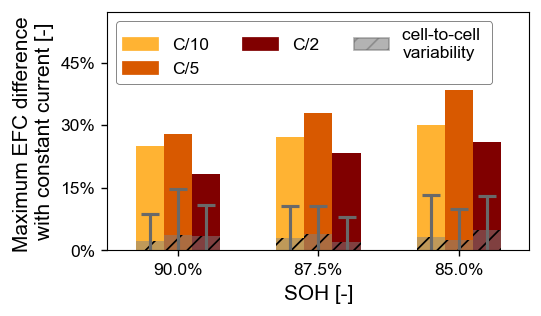

In [13]:
myhpadding  = 10
myvpadding = 10
current_colors_dic = plt.get_cmap('afmhot')(np.flip(np.linspace(0.25,0.6,3)))
bar_width = 1
my_cap_width = 1.8
my_intrinsic_color = 'dimgrey'

bar_positions = np.arange(len(labels))

fig,ax = plt.subplots(figsize = (4.5,2.38),dpi=mydpi/2)
plt.subplots_adjust(top=0.98, bottom =0.18, left=0.20, right=0.95)

for i, SOH_value in enumerate(SOH_values):
    ax.bar(bar_positions+(i-1)*5,variability[SOH_value], width=bar_width, color=current_colors_dic, label='Main Values')
    ax.bar(bar_positions+(i-1)*5,intr_var_mean[SOH_value],width=bar_width,color='grey', hatch='//',alpha = 0.5,zorder =2)
    ax.errorbar(bar_positions+(i-1)*5, [0,0,0], yerr=intr_var_max[SOH_value], linewidth = my_cap_width ,linestyle = 'none', color=my_intrinsic_color, capsize=5, capthick=my_cap_width,label='Error Bars')

# Customize the plot
ax.set_xlim([-6.5,8.5])
ax.set_ylim([0,0.57])
ax.set_xticks([-4,1,6])
ax.set_xticklabels([f"{soh * 100:.1f}%" for soh in SOH_values],fontsize = mytickfontsize)

my_yticks = [0, 0.15, 0.30,0.45]
ax.yaxis.set_major_locator(ticker.FixedLocator(my_yticks))
ax.set_yticklabels([f"{tick * 100:.0f}%" for tick in my_yticks],fontsize = mytickfontsize)

ax.set_xlabel('SOH [-]',fontsize = myfontsize)
ax.set_ylabel('Maximum EFC difference \nwith constant current [-]',fontsize = myfontsize)
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in current_colors_dic]
legend_handles.append(plt.Rectangle((0,0),1,1,color=my_intrinsic_color,alpha = 0.5,hatch = '//'))
mylegend = ax.legend(legend_handles, labels+['cell-to-cell \nvariability'],loc=2,ncol = 3,fontsize= mytickfontsize)
mylegend.get_frame().set_facecolor('white') 
mylegend.get_frame().set_edgecolor(myframecolor)
mylegend.get_frame().set_linewidth(legend_framewidth)
mylegend.get_frame().set_alpha(mylegendalpha/1.5)

#thickness of the frame
ax.spines['top'].set_linewidth(ax_framewidth)
ax.spines['bottom'].set_linewidth(ax_framewidth)
ax.spines['right'].set_linewidth(ax_framewidth)
ax.spines['left'].set_linewidth(ax_framewidth)

ax.spines['top'].set_color(myframecolor)
ax.spines['bottom'].set_color(myframecolor)
ax.spines['right'].set_color(myframecolor)
ax.spines['left'].set_color(myframecolor)

## Plotting 2.d

In [14]:
chosen_SOH = 0.85

#removing cells that didn't reach the chosen SOH
other_buckets['Co10_storage'] = [cell for cell in other_buckets['Co10_storage'] if cell not in ['cell_003','cell_004','cell_005']]

#getting the avg, std, errors in experimental C-rates and EFCs for the 3 main buckets
x_toplot_B3 = []
y_toplot_B3 = []
xmin_B3 = []
xmax_B3 = []
ymin_B3 = []
ymax_B3 = []
for k,v in buckets3.items():
    submerged = merged[merged['cell_name'].isin(v)]
    x_values = submerged.loc[:,"avg_crate_exp"]
    y_values = submerged.loc[:,chosen_SOH]
    x_toplot_B3.append(np.mean(x_values))
    y_toplot_B3.append(np.mean(y_values))
    xmax_B3.append(np.round(x_values.max()-np.mean(x_values),3))
    xmin_B3.append(np.round(abs(x_values.min()-np.mean(x_values)),3))
    ymax_B3.append(y_values.max()-np.mean(y_values))
    ymin_B3.append(abs(y_values.min()-np.mean(y_values)))
    
#getting the avg, std, errors in experimental C-rates and EFCs for all other_buckets
x_toplot = []
y_toplot = []
xmin = []
xmax = []
ymin = []
ymax = []
for k,v in other_buckets.items():
    submerged = merged[merged['cell_name'].isin(v)]
    x_values = submerged.loc[:,"avg_crate_exp"]
    y_values = submerged.loc[:,chosen_SOH]
    x_toplot.append(np.mean(x_values))
    y_toplot.append(np.mean(y_values))
    xmax.append(np.round(x_values.max()-np.mean(x_values),3))
    xmin.append(np.round(abs(x_values.min()-np.mean(x_values)),3))
    ymax.append(y_values.max()-np.mean(y_values))
    ymin.append(abs(y_values.min()-np.mean(y_values)))



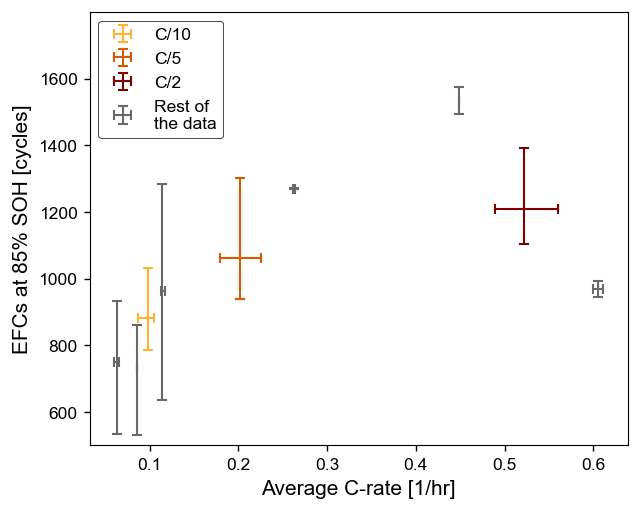

In [15]:
my_ylim =[500,1800]
fig,ax = plt.subplots(figsize=(5.252,4.23),dpi=mydpi/2)
plt.subplots_adjust(top=0.95, bottom =0.13, left=0.13, right=0.95)
mynewlinewidth = mylinewidth*1.5

for i,a,b,mina,maxa,minb,maxb in (zip([0,1,2],x_toplot_B3,y_toplot_B3,xmin_B3,xmax_B3,ymin_B3,ymax_B3)):
    ax.errorbar(a,b,xerr=np.reshape([mina,maxa],(2,1)),
                yerr=np.reshape([minb,maxb],(2,1)),fmt="none",
                ecolor =current_colors_dic[i],elinewidth = mynewlinewidth,capsize =3,mew = mynewlinewidth,label = f"C/{crates[i][2:]}")
ax.errorbar(x_toplot,y_toplot,xerr=[xmin,xmax],yerr=[ymin,ymax],fmt="none",ecolor ='dimgrey',elinewidth = mynewlinewidth,capsize =3,mew = mynewlinewidth,label = 'Rest of \nthe data')
ax.set_xlabel(r'Average C-rate [1/hr]',fontsize = myfontsize)
ax.set_ylabel(f'EFCs at {int(100*distribution_SOH)}% SOH [cycles]',fontsize  = myfontsize)
ax.set_ylim(my_ylim)
my_yticks = np.arange(100*(my_ylim[0]//100 + 1),my_ylim[1],200)
ax.yaxis.set_major_locator(ticker.FixedLocator(my_yticks))
ax.tick_params(axis='both', labelsize=mytickfontsize)
mylegend= ax.legend(loc=2,fontsize=mytickfontsize)
mylegend.get_frame().set_edgecolor(myframecolor)
mylegend.get_frame().set_linewidth(legend_framewidth)
mylegend.get_frame().set_alpha(mylegendalpha)

#thickness of the frame
ax.spines['top'].set_linewidth(ax_framewidth)
ax.spines['bottom'].set_linewidth(ax_framewidth)
ax.spines['right'].set_linewidth(ax_framewidth)
ax.spines['left'].set_linewidth(ax_framewidth)

ax.spines['top'].set_color(myframecolor)
ax.spines['bottom'].set_color(myframecolor)
ax.spines['right'].set_color(myframecolor)
ax.spines['left'].set_color(myframecolor)